## Chapter 2
# ~~Matlab~~ _Python_ Analysis of the Simplest Lowpass Filter

All Matlab examples are of course converted to code that runs here in a Python Jupyter notebook.

## Filter Implementation

We will use the built-in `lfilter` function from `scipy` (which is a close analogue to the build-in `filter` matlab method used in the book).

In [1]:
import numpy as np
from scipy.signal import lfilter

In [2]:
N = 10 # length of test input signal
x = np.arange(1, N + 1).astype(float) # test input signal (integer ramp)
B = [1,1] # transfer function numerator
A = [1] # transfer function denominator

y = lfilter(B, A, x)

for i in range(N):
    print('x(%d)=%f\ty(%d)=%f' % (i, x[i], i, y[i]))

x(0)=1.000000	y(0)=1.000000
x(1)=2.000000	y(1)=3.000000
x(2)=3.000000	y(2)=5.000000
x(3)=4.000000	y(3)=7.000000
x(4)=5.000000	y(4)=9.000000
x(5)=6.000000	y(5)=11.000000
x(6)=7.000000	y(6)=13.000000
x(7)=8.000000	y(7)=15.000000
x(8)=9.000000	y(8)=17.000000
x(9)=10.000000	y(9)=19.000000


_(Compare to Figure 2.1 on p28)_

In [3]:
# block-oriented version of simple lowpass filter (same output as above)
NB = N // 2 # block length

(y1, zF) = lfilter(B, A, x[:NB], zi=[0]) # process block 1
y2, _ = lfilter(B, A, x[NB:], zi=zF) # process block 2

for i in range(N):
    y_i = y1[i] if i < NB else y2[i - NB]
    print('x(%d)=%f\ty(%d)=%f' % (i, x[i], i, y_i))

x(0)=1.000000	y(0)=1.000000
x(1)=2.000000	y(1)=3.000000
x(2)=3.000000	y(2)=5.000000
x(3)=4.000000	y(3)=7.000000
x(4)=5.000000	y(4)=9.000000
x(5)=6.000000	y(5)=11.000000
x(6)=7.000000	y(6)=13.000000
x(7)=8.000000	y(7)=15.000000
x(8)=9.000000	y(8)=17.000000
x(9)=10.000000	y(9)=19.000000


## Simulated Sine-Wave Analysis

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def mod2pi(x):
    """Reduce x to the range [-pi, pi)"""
    y = x
    twopi = 2 * np.pi
    while y >= np.pi:
        y -= twopi
    while y < -np.pi:
        y += twopi
    return y

In [6]:
def sine_wave_analysis(t, f, B, A):
    amp_in = 1 # input signal amplitude
    phase_in = 0 # input signal phase
    
    N = len(f) # number of test frequencies
    gains = np.zeros(N) # pre-allocate amp-response array
    phases = np.zeros(N) # pre-allocate phase-response array
    if len(A) == 1:
        num_transients = len(B) - 1 # number of samples to steady state
    else:
        raise 'Need to set transient response duration here.'
    
    for k in range(len(f)): # loop over analysis frequencies
        test_sinusoid = amp_in * np.cos(2 * np.pi * f[k] * t + phase_in)
        y = lfilter(B, A, test_sinusoid)
        yss = y[num_transients:] # chop off transient
        # measure output amplitude as max (SHOULD INTERPOLATE):
        peak_loc = np.argmax(np.abs(yss))
        amp_out = np.abs(yss[peak_loc])
        gains[k] = amp_out / amp_in # amplitude response
        if amp_out < 1e-20:
            phase_out = 0
        else:
            sin_phase = 2 * np.pi * f[k] * (peak_loc + num_transients)
            # compute phase by inverting sinusoid (BAD METHOD):
            phase_out = np.arccos(yss[peak_loc] / amp_out) - sin_phase
            phase_out = mod2pi(phase_out) # reduce to [-pi, pi)
        phases[k] = phase_out - phase_in

        plt.figure(k)
        plt.subplot(211)
        plt.plot(t, test_sinusoid, '*k')
        plt.title('Filter Input Sinusoid, f(%d)=%0.2f' % (k, f[k]))
        t_interp = np.linspace(t[0], t[-1], t.size * 10)
        test_sinusoid_interp = amp_in * np.cos(2 * np.pi * f[k] * t_interp + phase_in)
        plt.plot(t_interp, test_sinusoid_interp, '--k')
        plt.subplot(212)
        plt.plot(t, y, '*k')
        plt.title('Filter Output Sinusoid')
        plt.tight_layout()
    return gains, phases

In [7]:
def freq_plot(f, y, symbol='', title='', xlabel='Frequency (Hz)', ylabel=''):
    if title:
        plt.title(title)
    plt.plot(f, y, symbol)
    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.grid(True)

In [8]:
def sine_wave_analysis_main_plot(gains, phases, frequencies):
    """Compare measured and theoretical frequency response."""

    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    freq_plot(frequencies, gains, '*k', 'Amplitude Response', ylabel='Gain')
    theoretical_amplitude_response = 2 * np.cos(np.pi * frequencies / fs)
    freq_plot(frequencies, theoretical_amplitude_response, '-k')

    plt.subplot(212)
    theoretical_phase_response = -np.pi * frequencies / fs
    phase_shift_cycles = 1 / (2 * np.pi)
    freq_plot(frequencies, theoretical_phase_response * phase_shift_cycles, '-k', 'Phase Response', ylabel='Phase shift (cycles)')
    freq_plot(frequencies, phases * phase_shift_cycles, '*k')
    plt.tight_layout()

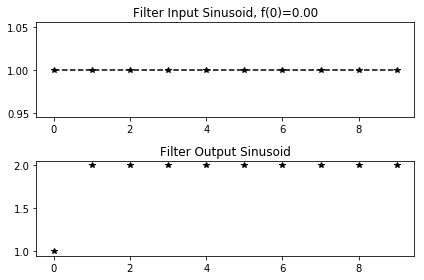

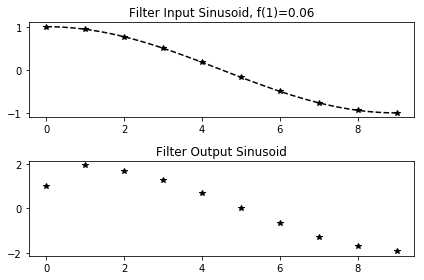

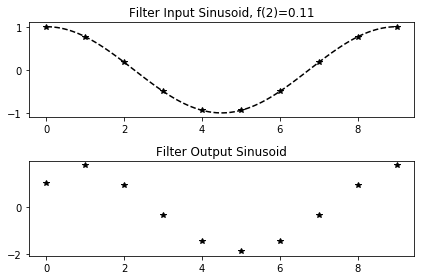

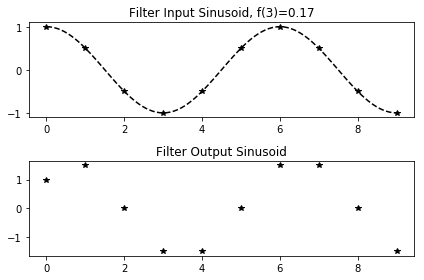

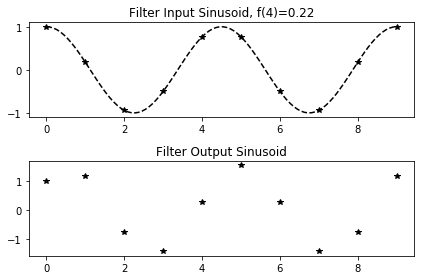

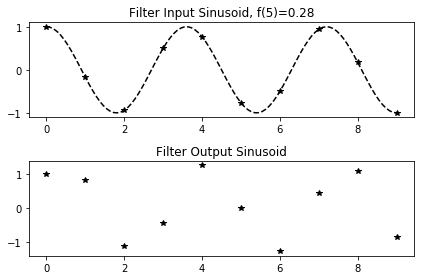

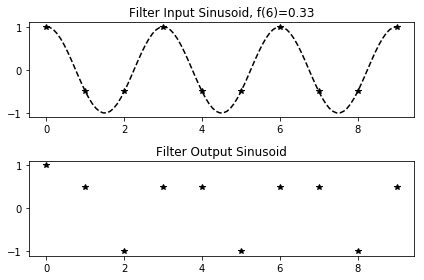

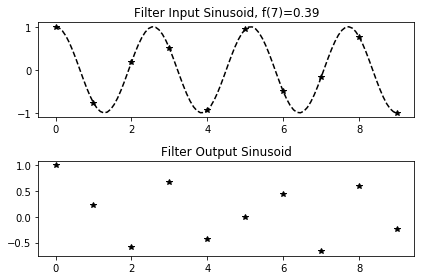

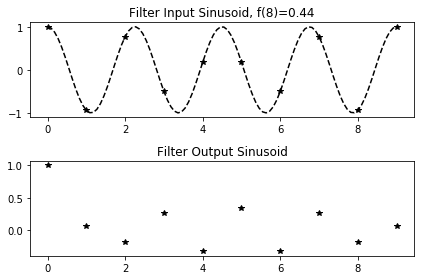

In [9]:
fs = 1

f_max = fs / 2
df = f_max / (N - 1) # spacing between frequencies
f = np.arange(0, f_max, df) # sampled frequency axis
dt = 1 / fs # sampling interval in seconds
t_max = 10 # number of seconds to run each sine test
t = np.arange(0, t_max, dt) # sampled time axis

gains, phases = sine_wave_analysis(t, f/fs, B, A)

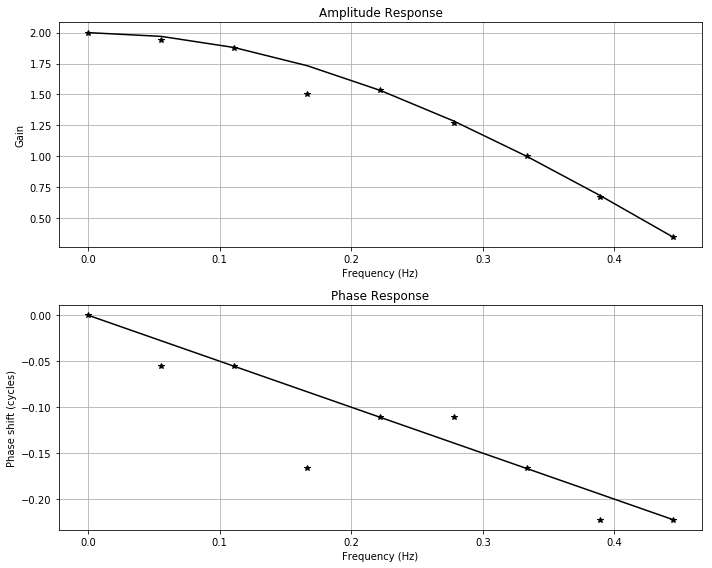

In [10]:
sine_wave_analysis_main_plot(gains, phases, f)

_Compare to Figure 2.7 on p35._

The main source of error of the experimental frequency response compared with the theoretical response, show above, is that the gain and phase shift are measured in reference to a peak amplitude that is measured only to the nearest sample.

The error can be improved to arbitrary accuracy by interpolation and by choosing a sampling rate unrelated to the test frequencies.

## Complex Sine-Wave Analysis

Since we can measure the _instantaneous_ amplitude and phase of a complex signal, we can dramatically improve the accuracy of the sine-wave analysis technique by usine complex test signals:

In [11]:
vmod2pi = np.vectorize(mod2pi)

def sine_wave_analysis_complex(t, f, B, A):
    amp_in = 1 # input signal amplitude
    phase_in = 0 # input signal phase
    
    N = len(f) # number of test frequencies
    gains = np.zeros(N) # pre-allocate amp-response array
    phases = np.zeros(N) # pre-allocate phase-response array
    if len(A) == 1:
        num_transients = len(B) - 1 # number of samples to steady state
    else:
        raise 'Need to set transient response duration here.'
    
    for k in range(len(f)): # loop over analysis frequencies
        test_sinusoid = amp_in * np.exp(1j * 2 * np.pi * f[k] * t + phase_in)
        y = lfilter(B, A, test_sinusoid)
        yss = y[num_transients:] # chop off transient
        amp_out = np.mean(np.abs(yss))
        gains[k] = amp_out / amp_in # amplitude response
        sss = test_sinusoid[num_transients:] # align with yss
        phases[k] = np.mean(vmod2pi(np.angle(yss * np.conj(sss))))

    return gains, phases

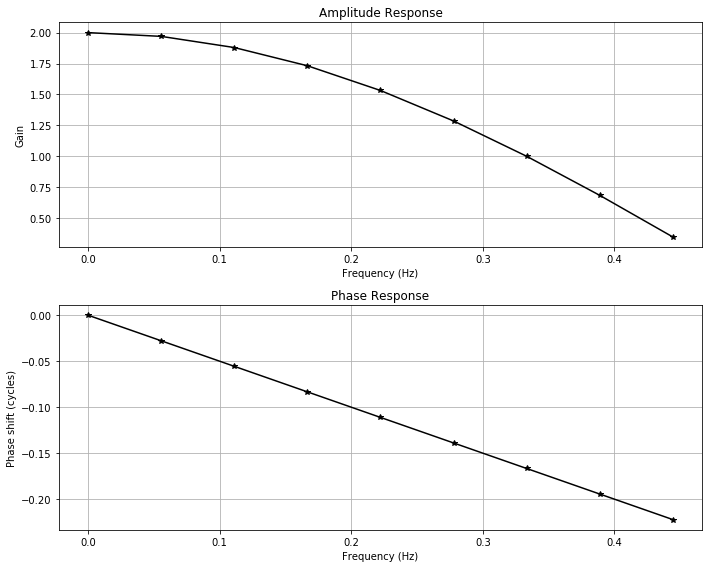

In [12]:
gains, phases = sine_wave_analysis_complex(t, f/fs, B, A)
sine_wave_analysis_main_plot(gains, phases, f)

## Practical Frequency-Response Analysis

In practice, the FFT is normally used for frequency response analysis:

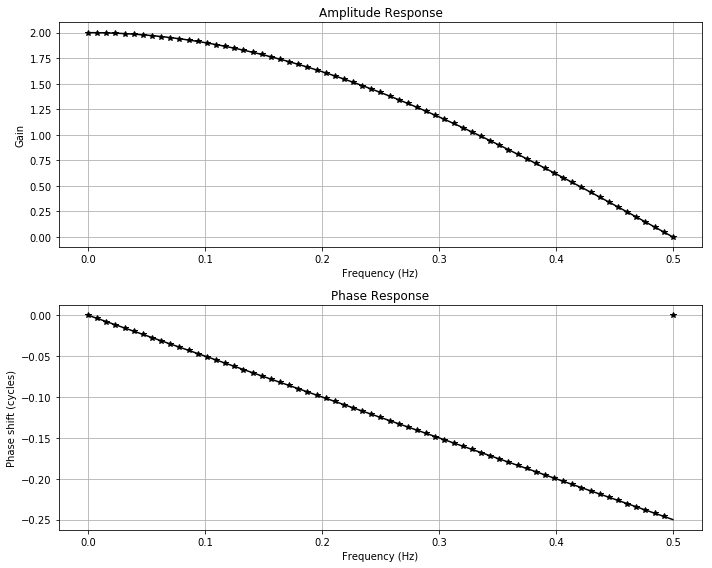

In [13]:
B = [1, 1] # filter feedforward coefficients
A = [1] # filter feedback coefficients

N = 128 # FFT size
fs = 1

H = np.fft.fft(B, N) # automatically zero-pads
# Discard negative-frequency samples (but keep the samples at dc and fs / 2)
Hnnf = H[:N // 2 + 1]
f = np.arange(N // 2 + 1) * fs / N # frequency axis in Hz
gains = np.abs(Hnnf) # amplitude response
phases = np.angle(Hnnf) # phase response

sine_wave_analysis_main_plot(gains, phases, f)

## Elementary ~~Matlab~~ _Python_ Problems

**1) Using the complex "test sinusoid"**

$x(n) = Ae^{j(\omega nT + \phi)}$,

**find the signal**

$y(n) = x(n) - x(n-1)$ (2.2)

**in polar form.**

_(I will keep the amplitude and phase offset of this sinusoid in the derivation for this one, even though they are not needed as demonstrated in Ch1 problem 1. Also note that this exact filter is derived more simply in Ch1 problem 2. Just repeating here for clarity and practice.)_


$\begin{align}
y(n) &= x(n) - x(n-1)\\
&= Ae^{j(\omega nT + \phi)} - Ae^{j(\omega (n-1)T + \phi)}\\
&= A(e^{j(\omega nT + \phi)} - e^{j(\omega (n-1)T + \phi)})\\
&= Ae^{j\phi}(e^{j\omega nT} - e^{j\omega (n-1)T})\\
&= Ae^{j\phi}(e^{j\omega nT} - e^{j\omega nT}e^{-j\omega T})\\
&= Ae^{j\phi}e^{j\omega nT}(1 - e^{-j\omega T})\\
&= x(n)(1 - e^{-j\omega T})\\
&= (e^{j\omega T/2} - e^{-j\omega T/2})e^{-j\omega T/2}x(n)\\
&= 2j\sin(\omega T/2)e^{-j\omega T/2}x(n)\\
\end{align}$

**a) Regarding (2.2) as the definition of a digital filter, find its frequency response.**

Amplitude response:

$\begin{align}
G(\omega) &= \left|2j\sin(\omega T/2)e^{-j\omega T/2}\right|\\
&= 2\left|\sin(\omega T/2)\right|\\
&= 2\sin(\omega T/2) = 2\sin(\pi f T), 0 \leq f \leq f_s\\
\end{align}$

Phase response:

$\begin{align}
\Theta(\omega) &= \angle 2j\sin(\omega T/2)e^{-j\omega T/2}\\
&= \angle j - \angle e^{-j\omega T/2}\\
&= \frac{\pi}{2} -\frac{\omega T}{2}\\
&= \frac{\pi}{2} -\pi f T\\
\end{align}$

**b) Find and plot the amplitude response.**

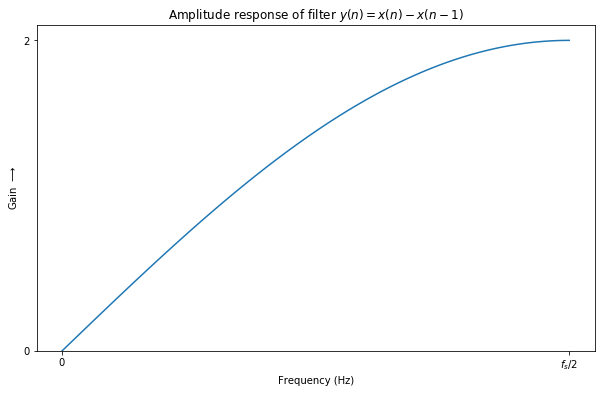

In [15]:
T = 1
frequency_range = np.linspace(0, fs / 2, 100)
G = 2 * np.sin(np.pi * frequency_range * T)

plt.figure(figsize=(10, 6))
plt.plot(frequency_range, G)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $\\longrightarrow$')
plt.ylim(0, 2.1)
plt.xticks([0, fs / 2], [0, '$f_s/2$'])
plt.yticks([0, 2])
_ = plt.title('Amplitude response of filter $y(n) = x(n) - x(n-1)$')

**c) Find and plot the phase response.**

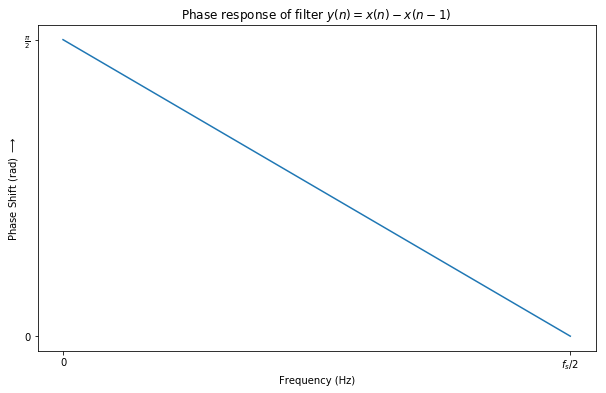

In [16]:
phase_response = np.pi / 2 - np.pi * frequency_range * T
plt.figure(figsize=(10, 6))
plt.plot(frequency_range, phase_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Shift (rad) $\\longrightarrow$')
plt.xticks([0, fs / 2], [0, '$f_s/2$'])
plt.yticks([0, np.pi / 2], [0, '$\\frac{\\pi}{2}$'])
_ = plt.title('Phase response of filter $y(n) = x(n) - x(n-1)$')

**d) What kind of filter is this? [Hint: It's not a lowpass filter.]**

The amplitude response is that of a highpass filter.

**2) Translate the phase response obtained in the previous problem to _time delay_ in seconds (as a function of frequency).**

To find the time delay in seconds, we express the phase in terms of the frequency and the sample period in seconds:

$\Theta(f) =\frac{\pi}{2} -\pi f T$ seconds

**3) Consider now the digital filter**

$y(n) = 3x(n) + 2x(n - 2)$.

**a) Find and plot the amplitude response.**

Let $x(n) \triangleq e^{j\omega nT}$.

$\begin{align}
y(n) &= 3x(n) + 2x(n-2)\\
&= 3e^{j\omega nT} + 2e^{j\omega(n - 2)T}\\
&= 3e^{j\omega nT} + 2e^{j\omega nT}e^{-j\omega 2T}\\
&= (3 + 2e^{-j\omega 2T})e^{j\omega nT}\\
&= (3 + 2e^{-j\omega 2T})x(n)\\
&= (3 + 2e^{-j4\pi fT})x(n)\\
&= (2\cos(4\pi fT) + 3 - 2j\sin(4\pi fT))x(n)\\
\end{align}$

Amplitude response:

$\begin{align}
G(\omega) &= \sqrt{(2\cos(4\pi fT) + 3)^2 + (2\sin(4\pi fT))^2}\\
&= \sqrt{(2\cos(4\pi fT) + 3)^2 + 4\sin^2(4\pi fT)}\\
\end{align}$

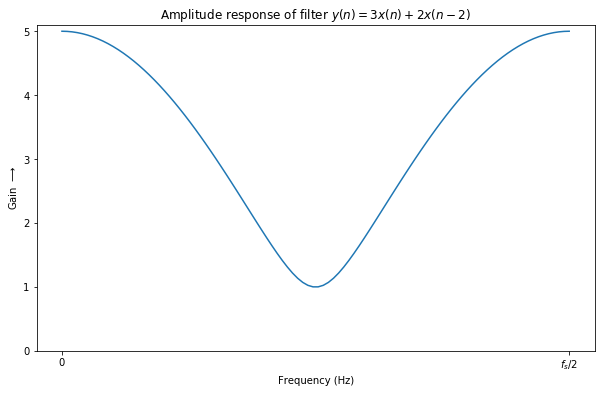

In [17]:
#G = np.abs(3 + 2 * np.exp(-4j * np.pi * frequency_range * T))
G = np.sqrt((2 * np.cos(4 * np.pi * frequency_range * T) + 3) ** 2 + 4*np.sin(4 * np.pi * frequency_range * T) ** 2)

plt.figure(figsize=(10, 6))
plt.plot(frequency_range, G)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $\\longrightarrow$')
plt.ylim(0, 5.1)
plt.xticks([0, fs / 2], [0, '$f_s/2$'])
_ = plt.title('Amplitude response of filter $y(n) = 3x(n) + 2x(n-2)$')

**b) Find and plot the phase response.**

Phase response:

$\begin{align}
\Theta(\omega) &= \angle (3 + 2e^{-j4\pi fT})\\
&= \angle (2\cos(4\pi fT) + 3 - 2j\sin(4\pi fT))\\
&= \tan^{-1}\left[- 2j\sin(4\pi fT)/(2\cos(4\pi fT) + 3)\right]
\end{align}$

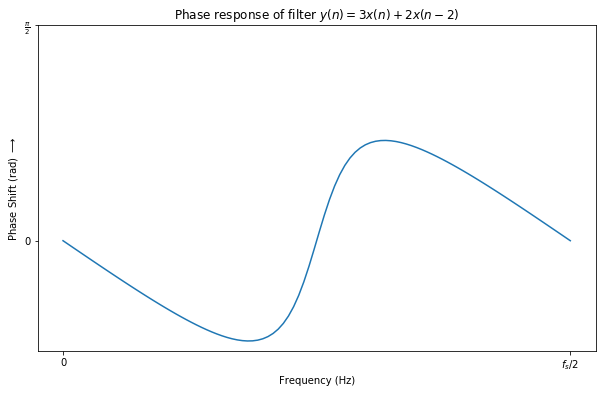

In [18]:
phase_response = np.arctan2(-2 * np.sin(4 * np.pi * frequency_range * T), (3 + 2 * np.cos(4 * np.pi * frequency_range * T)))
plt.figure(figsize=(10, 6))
plt.plot(frequency_range, phase_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Shift (rad) $\\longrightarrow$')
plt.xticks([0, fs / 2], [0, '$f_s/2$'])
plt.yticks([0, np.pi / 2], [0, '$\\frac{\\pi}{2}$'])
_ = plt.title('Phase response of filter $y(n) = 3x(n) + 2x(n-2)$')

**4) Consider the arctangent function**

$\theta = \tan^{-1}(\frac{y}{x})$,

**where $x$ and $y$ can be any real number.**

**a) What is the range of $\theta$?**

$\theta \in (-\frac{\pi}{2}, \frac{\pi}{2})$

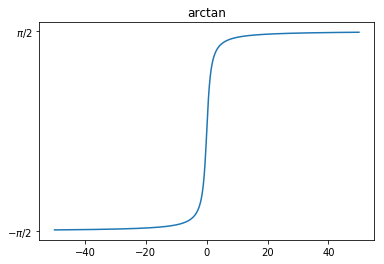

In [19]:
x = np.linspace(-50, 50, 1000)
plt.plot(x, np.arctan(x))
plt.yticks([-np.pi / 2, np.pi / 2], ['$-\\pi/2$', '$\\pi/2$'])
_ = plt.title('arctan')

**b) What is the name of the matlab arctangent function whose output range is $-\pi$ to $\pi$?**

In Matlab, [it looks like](https://www.mathworks.com/help/symbolic/mupad_ref/arctan.html) `arctan` is the name of this function, but it is overloaded to accept two arguments.

In `numpy`, however, [`arctan2`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.arctan2.html) is what we want:

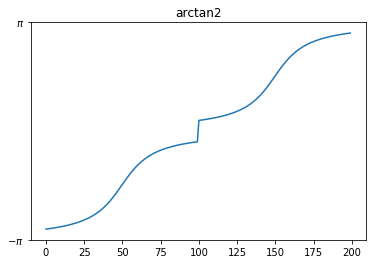

In [20]:
x = np.append(np.linspace(-np.pi, np.pi, 100), np.linspace(np.pi, -np.pi, 100))
y = np.append(np.full(100, -1), np.full(100, 1))
plt.plot(np.arctan2(y, x))
plt.yticks([-np.pi, np.pi], ['$-\\pi$', '$\\pi$'])
_ = plt.title('arctan2')

**5) Write a matlab script that generates a sinusoidal wave:**

**a) Set the sampling rate to 44100 samples per second.  
b) Set the sinusoid length to 5 seconds.  
c) Set the amplitude level to -6 dB (relative to maximum)
d) Set the frequency to 440 Hz
e) Save the wave as a sound file named `mysound.wav`** (Instead of saving it locally I'm just going to play it here.)

In [21]:
fs = 44100
length_seconds = 5
amplitude_db = -6
amplitude_linear = 10 ** (amplitude_db / 20)
f = 440
t = np.linspace(0, length_seconds, length_seconds * fs)

sinusoid = amplitude_linear * np.sin(2 * np.pi * f * t)

In [22]:
from IPython.display import Audio

Audio(sinusoid, rate=fs)

**6) _Additive synthesis_  
A sum of cosine waves can be given by**

$x(t) = \sum_\limits{k=1}^\limits{N}A_k\cos(2\pi f_k t + \phi_k)$,

**where $A_k$, $f_k$, and $\phi_k$ mean the peak amplitude, frequency, and initial phase of the $k_{th}$ sinusoidal component.  
Write a Matlab function that implements this synthesis method and saves the result as an audio file. The syntax of your function should be:** _(Adapting for Python, and again rendering inline instead of saving as file)_

```
def additive(f, A, fs, dur):
    """
    f: vector of frequencies in Hz
    A: vector of complex amplitudes A*e^(j*phase)
    fs: sampling rate in Hz
    dur: total duration of the signal in seconds
    f and Z must be of the same length:
    Z(1) corresponds to f(1) and so on.
    """
```

In [23]:
def additive(f, A, fs, dur):
    """
    f: vector of frequencies in Hz
    A: vector of complex amplitudes A*e^(j*phase)
    fs: sampling rate in Hz
    dur: total duration of the signal in seconds
    name: name of the output audio file
    f and Z must be of the same length:
    Z(1) corresponds to f(1) and so on.
    """
    
    return np.sum(np.dot(A.reshape(1, -1), np.cos(np.outer(2 * np.pi * f, np.linspace(0, dur, dur * fs)))), axis=0)

In [24]:
f = np.arange(10) * 440 # generate A and 9 harmonics
A = np.linspace(1, 0, 10, endpoint=False)
harmonics = additive(f, A, fs, 5)

Audio(harmonics, rate=fs)

Plot the spectrum just for fun:

(-0.15, 0.15)

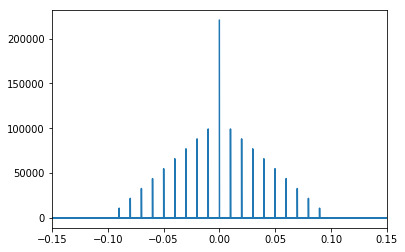

In [25]:
plt.plot(np.fft.fftfreq(harmonics.size), np.abs(np.fft.fft(harmonics)))
plt.xlim(-0.15, 0.15)